Optimal Threshold: 1.5


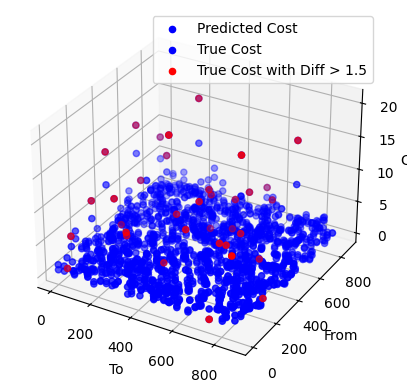

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load and preprocess data (replace this with your data loading and preprocessing steps)
data = pd.read_csv('../code/CSR/data/PEMS07/PEMS07.csv')
X = data[['to', 'from']]
y = data['cost']

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.arange(1, 10, 0.5)  # Range of threshold values to test
mae_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

# Calculate mean MAE for each threshold value
mean_mae_scores = []
for threshold in thresholds:
    mae_threshold = []
    for mae in mae_scores:
        mae_threshold.append(1 if mae > threshold else 0)
    mean_mae_scores.append(np.mean(mae_threshold))

# Find the optimal threshold value
optimal_threshold = thresholds[np.argmin(mean_mae_scores)]
print(f'Optimal Threshold: {optimal_threshold}')

# Train the final model with the optimal threshold
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict 'cost' for the entire dataset
data['predicted_cost'] = model.predict(X)

# Calculate absolute difference between true cost and predicted cost
data['absolute_difference'] = abs(data['cost'] - data['predicted_cost'])

# Create 3D graph with the optimal threshold
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Mark points with significant difference as green using the optimal threshold
ax.scatter(data['to'], data['from'], data['predicted_cost'], c='b', marker='o', label='Predicted Cost')
ax.scatter(data['to'], data['from'], data['cost'], c='b', label='True Cost')
green_indices = data[data['absolute_difference'] > optimal_threshold].index
ax.scatter(data.loc[green_indices, 'to'], data.loc[green_indices, 'from'], data.loc[green_indices, 'cost'],
           c='r', label=f'True Cost with Diff > {optimal_threshold}')

ax.set_xlabel('To')
ax.set_ylabel('From')
ax.set_zlabel('Cost')
ax.legend()
plt.show()


Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 1.1846 - val_loss: 1.2285
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 1.1673 - val_loss: 1.2114
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 1.1504 - val_loss: 1.1939
Epoch 4/50
22/22 [==============================] - 0s 993us/step - loss: 1.1336 - val_loss: 1.1762
Epoch 5/50
22/22 [==============================] - 0s 971us/step - loss: 1.1162 - val_loss: 1.1588
Epoch 6/50
22/22 [==============================] - 0s 953us/step - loss: 1.0989 - val_loss: 1.1409
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 1.0813 - val_loss: 1.1233
Epoch 8/50
22/22 [==============================] - 0s 1ms/step - loss: 1.0638 - val_loss: 1.1056
Epoch 9/50
22/22 [==============================] - 0s 980us/step - loss: 1.0466 - val_loss: 1.0877
Epoch 10/50
22/22 [==============================] - 0s 991us/step - loss: 1.0293 - val_loss: 1.0705
Epoch 11/

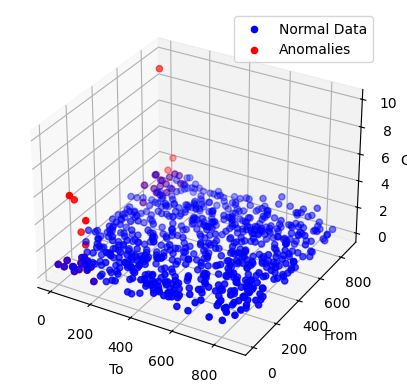

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load and preprocess data (replace this with your data loading and preprocessing steps)
data = pd.read_csv('../code/CSR/data/PEMS07/PEMS07.csv')
X = data[['to', 'from']]
y = data['cost']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 2  # Adjust as needed
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)

# Create autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Use the trained autoencoder for anomaly detection
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - X_pred), axis=1)  # Calculate mean squared error
threshold = np.percentile(mse, 95)  # Adjust percentile as needed

# Mark anomalies
anomalies = data[mse > threshold]

# Create 3D graph with anomalies marked
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot normal data
ax.scatter(X[y <= threshold].iloc[:, 0], X[y <= threshold].iloc[:, 1], y[y <= threshold], c='b', label='Normal Data')
# Plot anomalies
ax.scatter(anomalies['to'], anomalies['from'], anomalies['cost'], c='r', label='Anomalies')

ax.set_xlabel('To')
ax.set_ylabel('From')
ax.set_zlabel('Cost')
ax.legend()
plt.show()


Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 1.4261 - val_loss: 1.4910
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 1.4072 - val_loss: 1.4712
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 1.3889 - val_loss: 1.4522
Epoch 4/50
22/22 [==============================] - 0s 1ms/step - loss: 1.3711 - val_loss: 1.4339
Epoch 5/50
22/22 [==============================] - 0s 1ms/step - loss: 1.3536 - val_loss: 1.4161
Epoch 6/50
22/22 [==============================] - 0s 1ms/step - loss: 1.3368 - val_loss: 1.3988
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 1.3205 - val_loss: 1.3813
Epoch 8/50
22/22 [==============================] - 0s 2ms/step - loss: 1.3041 - val_loss: 1.3645
Epoch 9/50
22/22 [==============================] - 0s 2ms/step - loss: 1.2880 - val_loss: 1.3477
Epoch 10/50
22/22 [==============================] - 0s 1ms/step - loss: 1.2719 - val_loss: 1.3305
Epoch 11/50
22/22 [

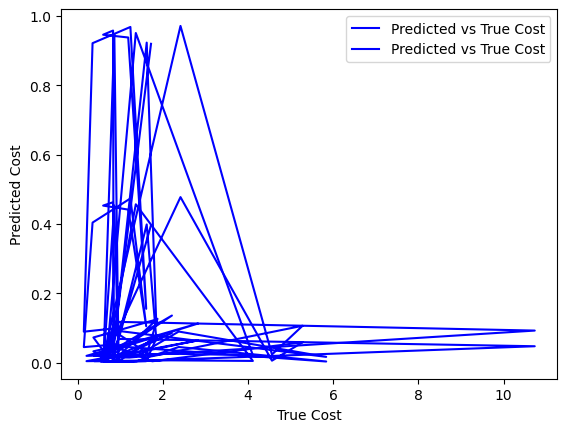

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess data (replace this with your data loading and preprocessing steps)
data = pd.read_csv('../code/CSR/data/PEMS07/PEMS07.csv')
X = data[['to', 'from']]
y = data['cost']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 2  # Adjust as needed
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)

# Create autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Use the trained autoencoder for anomaly detection
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - X_pred), axis=1)  # Calculate mean squared error
threshold = np.percentile(mse, 95)  # Adjust percentile as needed

# Filter y and X_pred based on anomalies
anomalies = data[mse > threshold]
y_anomalies = y[data.index.isin(anomalies.index)]
X_pred_anomalies = X_pred[data.index.isin(anomalies.index)]

# Plot the true cost vs predicted cost for anomalies
plt.plot(y_anomalies, X_pred_anomalies, 'b-', label='Predicted vs True Cost')
plt.xlabel('True Cost')
plt.ylabel('Predicted Cost')
plt.legend()
plt.show()
